# Cryoscope Analysis tutorial

This tutorial shows an example of a cryoscope analysis using Savitzky-Golay filtering. We will load a dataset and analyse the data to fit a single and double exponential rise. 

#### Install and import packages

In [ ]:
!uv pip install numpy matplotlib xarray scipy qualibrate git+https://github.com/qua-platform/qualibration-libs.git git+https://github.com/qua-platform/quam-builder.git --prerelease=allow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from qualibration_libs.analysis.models import expdecay, two_expdecay
from qualibration_libs.analysis.fitting import cryoscope_frequency
from scipy.optimize import curve_fit, minimize
from scipy.signal import convolve, deconvolve, lfilter
from qualang_tools.digital_filters import calc_filter_taps


2025-05-20 15:25:12,210 - qm - INFO     - Starting session: e8b67bf5-a9da-4fe6-8947-54e8ff22819e


In [2]:
# Load the data
data = xr.open_dataset("./data/ds_0.h5")

In [3]:
# Visualize the data structure
data

<xarray.Dataset> Size: 16kB
Dimensions:  (time: 800, axis: 2, qubit: 1)
Coordinates:
  * time     (time) int32 3kB 1 2 3 4 5 6 7 8 ... 794 795 796 797 798 799 800
  * axis     (axis) object 16B 'x' 'y'
  * qubit    (qubit) object 8B 'q1'
Data variables:
    state    (qubit, time, axis) float64 13kB ...

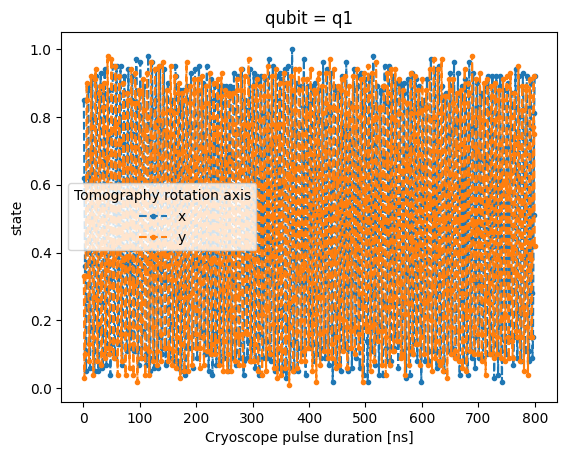

In [4]:
# Select the qubit index to analyze and plot the raw experimental data

qubit = 'q1'

data.state.sel(qubit=qubit).plot.line(x="time", linestyle="--", marker=".")

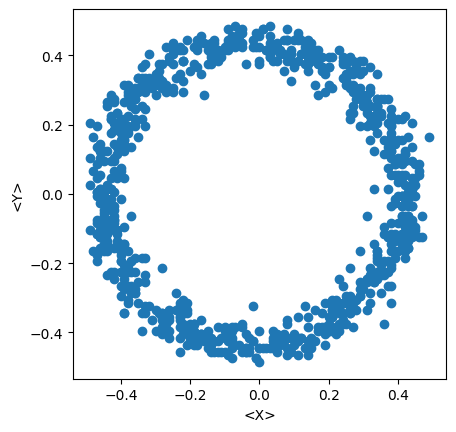

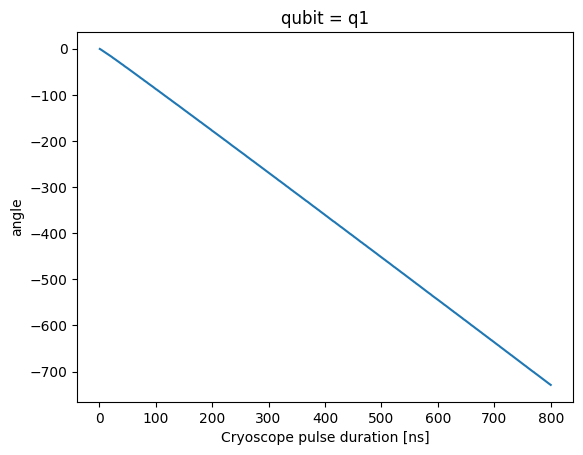

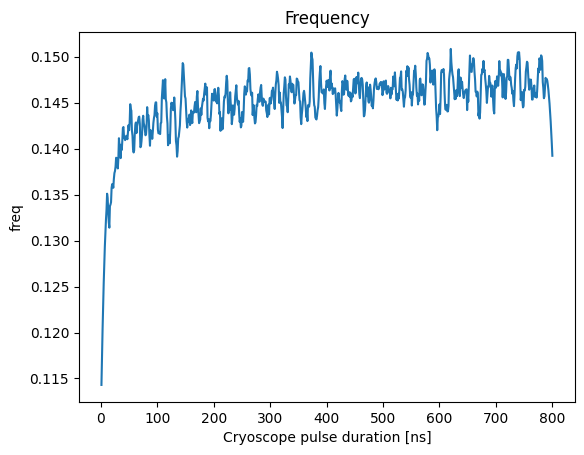

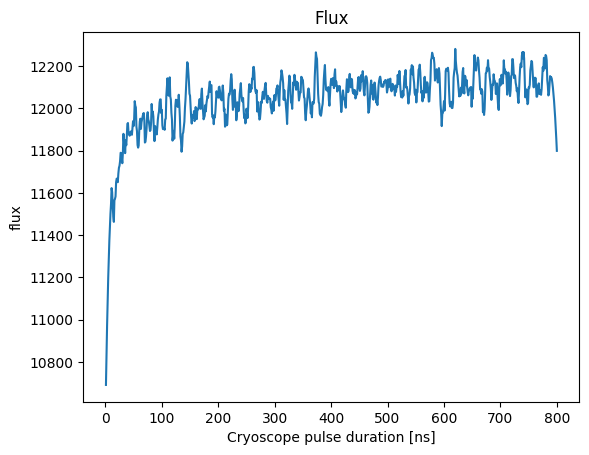

In [5]:
# Hardcoded parameters for Savitzky-Golay filter:
sg_order = 3
sg_range = 20


data = data.state.sel(qubit=qubit)

# This method filters the data using a Savitzky-Golay filter and reconstructs the signal from the <X> and <Y> decomposition
flux_cryoscope_q = cryoscope_frequency(
    data,
    quad_term=-1, # leave as -1
    stable_time_indices=(50, 700), # Hardcoded stable time indices (where the frequency is trace is flat)
    sg_order=sg_order,
    sg_range=sg_range,
    plot=True,
)

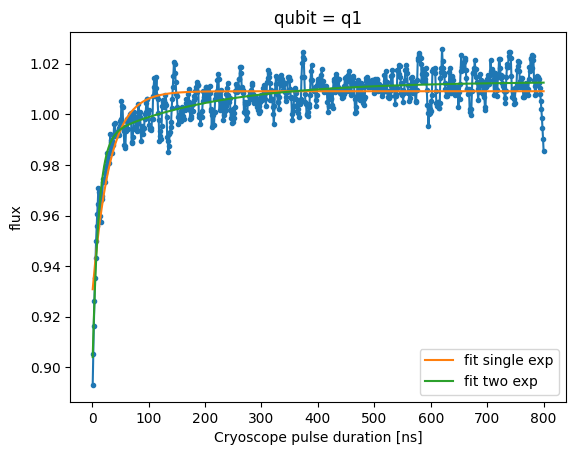

Fit2 parameters (two_expdecay function):
s: 1.012942
a: -0.093025
t: 10.538038
a2: -0.023018
t2: 196.918044

Fit parameters (expdecay function):
s: 1.009140
a: -0.080166
t: 30.231582


In [6]:
# Fit the data with a single and a double exponential decay function

da = flux_cryoscope_q

# Hardcoded fit guesses:
first_vals = da.sel(time=slice(0, 1)).mean().values
final_vals = da.sel(time=slice(50, None)).mean().values

try:
    p0 = [final_vals, -1 + first_vals / final_vals, 50]
    fit, _ = curve_fit(expdecay, da.time, da, p0=p0)
except:
    fit = p0
    print("single exp fit failed")
try:
    p0 = [fit[0], fit[1], 5, fit[1], fit[2]]
    fit2, _ = curve_fit(two_expdecay, da.time, da, p0=p0)
except:
    fit2 = p0
    print("two exp fit failed")


da.plot(marker=".")
plt.plot(da.time, expdecay(da.time, *fit), label="fit single exp")
if fit2 is not None:
    plt.plot(da.time, two_expdecay(da.time, *fit2), label="fit two exp")
plt.legend()
plt.show()

# Print fit2 parameters nicely (two_expdecay function)
if fit2 is not None:
    print("Fit2 parameters (two_expdecay function):")
    print(f"s: {fit2[0]:.6f}")
    print(f"a: {fit2[1]:.6f}")
    print(f"t: {fit2[2]:.6f}")
    print(f"a2: {fit2[3]:.6f}")
    print(f"t2: {fit2[4]:.6f}")

# Print fit parameters nicely (expdecay function)
print("\nFit parameters (expdecay function):")
print(f"s: {fit[0]:.6f}")
print(f"a: {fit[1]:.6f}")
print(f"t: {fit[2]:.6f}")




/Users/paul/.venv/lib/python3.12/site-packages/qualang_tools/digital_filters/filters.py:332: UserWarning: The feedforward taps reached the maximum value of 1.9999847412109375.
The coefficients are scaled down to stay within the valid range which reduces the outputted amplitude of the pulses played through the filtered port by a factor of 1.070.


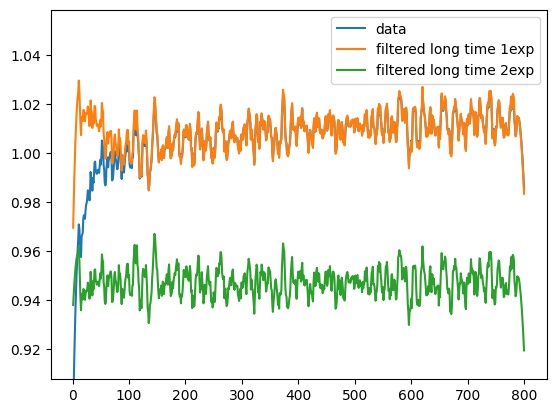

In [7]:
# Calculate the filter taps for the exponential decay functions. If you use a different fit function,
# you need to adapt the filter taps calculation accordingly.

feedforward_taps_1exp, feedback_tap_1exp = calc_filter_taps(exponential=list(zip([fit[1] * 1.0], [fit[2]])))
feedforward_taps_2exp, feedback_tap_2exp = calc_filter_taps(
    exponential=list(zip([fit2[1], fit2[3]], [fit2[2], fit2[4]]))
)

FIR_1exp = feedforward_taps_1exp
FIR_2exp = feedforward_taps_2exp
IIR_1exp = [1, -feedback_tap_1exp[0]]
IIR_2exp = convolve([1, -feedback_tap_2exp[0]], [1, -feedback_tap_2exp[1]], mode="full")

filtered_response_long_1exp = lfilter(FIR_1exp, IIR_1exp, flux_cryoscope_q)
filtered_response_long_2exp = lfilter(FIR_2exp, IIR_2exp, flux_cryoscope_q)


f, ax = plt.subplots()
ax.plot(flux_cryoscope_q.time, flux_cryoscope_q, label="data")
ax.plot(flux_cryoscope_q.time, filtered_response_long_1exp, label="filtered long time 1exp")
ax.plot(flux_cryoscope_q.time, filtered_response_long_2exp, label="filtered long time 2exp")
ax.set_ylim([final_vals * 0.9, final_vals * 1.05])
ax.legend()

plt.show()